# 1. The training of a **model on the dataset as is.

In [40]:
#mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

#path of example directory
path = "/content/gdrive/MyDrive/Assignment/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy
import random

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

In [4]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale = (0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [7]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '//content/gdrive/MyDrive/Assignment/fruit_dataset1 (1)'

train_directory = os.path.join(dataset, 'train')
# valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)


# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [8]:
os.listdir(train_directory)

['durian', 'tomato', 'watermelon', 'pumpkin']

In [9]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True,
                                     drop_last=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [10]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [12]:
model_ft = models.resnet18(weights=True)  #if False, the weight will randomly initialized
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 10.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
#Train the model for 20 epochs
 
num_epochs = 20
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 0.9560, Accuracy: 58.9251%, 
		Validation : Loss : 1.4810, Accuracy: 50.1548%, Time: 226.4168s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.6721, Accuracy: 75.8157%, 
		Validation : Loss : 1.3372, Accuracy: 67.1827%, Time: 7.2874s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.5917, Accuracy: 77.9271%, 
		Validation : Loss : 1.2703, Accuracy: 75.5418%, Time: 6.5708s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.6059, Accuracy: 76.1996%, 
		Validation : Loss : 1.1445, Accuracy: 79.2570%, Time: 6.4975s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.5517, Accuracy: 81.7658%, 
		Validation : Loss : 1.0567, Accuracy: 81.1146%, Time: 6.6198s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.5479, Accuracy: 79.2706%, 
		Validation : Loss : 1.0476, Accuracy: 80.8050%, Time: 6.4975s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.4996, Accuracy: 83.3013%, 
		Validation : Loss : 1.0102, Accuracy: 83.2817%, Time: 6.6020s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.5125, Accuracy: 8

# 2. The training of the model on the dataset after modification to improve the performance of the model.

In [15]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale = (0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}


In [23]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/gdrive/MyDrive/Assignment/fruit_dataset1 (1)/'

train_directory = os.path.join(dataset, 'train')
# valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)


# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [24]:
os.listdir(train_directory)

['durian', 'tomato', 'watermelon', 'pumpkin']

In [25]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True,
                                     drop_last=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

521
323


In [26]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [27]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [28]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(weights=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.bn1(self.relu(self.fc0(output)))
       # output = self.bn2(self.relu(self.fc1(output)))
        output = self.classifier(output)
                
        return output
    
model_ft = model_ft.to(device)
    
model_ft = MyCustomResnet18()

criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
#Train the model for 20 epochs
 
num_epochs = 20
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 1.1711, Accuracy: 51.8234%, 
		Validation : Loss : 0.7704, Accuracy: 74.3034%, Time: 7.5797s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.8317, Accuracy: 73.1286%, 
		Validation : Loss : 0.6333, Accuracy: 78.3282%, Time: 6.6118s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.7220, Accuracy: 79.2706%, 
		Validation : Loss : 0.5896, Accuracy: 81.7337%, Time: 6.7135s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.6713, Accuracy: 78.1190%, 
		Validation : Loss : 0.4939, Accuracy: 84.8297%, Time: 6.6137s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.6083, Accuracy: 80.8061%, 
		Validation : Loss : 0.5177, Accuracy: 84.5201%, Time: 6.6637s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.6729, Accuracy: 77.5432%, 
		Validation : Loss : 0.5555, Accuracy: 83.9009%, Time: 6.6145s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.5218, Accuracy: 83.1094%, 
		Validation : Loss : 0.5264, Accuracy: 84.8297%, Time: 6.6416s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.5985, Accuracy: 82.

# 3. The training of the model on the dataset after data-centric strategies.
        # Changes: 
        # Add more data into the train folder
        # Analyse class for train folder and remove unnecessary noise from the classes

In [32]:
# Applying Transforms to the Data
import torchvision
import torchvision.transforms as transforms

image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale = (0.8,1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [33]:
# Load the Data

# Set train and valid directory paths

# dataset = '/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset'
dataset = '/content/gdrive/MyDrive/Assignment/fruit_dataset2/'

train_directory = os.path.join(dataset, 'train')
# valid_directory = os.path.join(dataset, 'validation')
test_directory = os.path.join(dataset, 'validation')

# Batch size
batchSize = 8

# Number of classes
num_classes = len(os.listdir(train_directory))
print(num_classes)


# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),

    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
# idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
# print(idx_to_class)

4


In [34]:
os.listdir(train_directory)

['tomato', 'watermelon', 'pumpkin', 'durian']

In [35]:
#######################################################
#                  Create Dataloader                     #
#######################################################

# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
trainloader = DataLoader(dataset=data['train'], # use custom created train Dataset
                                     batch_size=4, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True,
                                     drop_last=True) # shuffle the data?

testloader = DataLoader(dataset=data['test'], # use custom created test Dataset
                                    batch_size=4, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_data_size = len(trainloader.dataset)
test_data_size = len(testloader.dataset)

print(train_data_size)
print(test_data_size)

560
323


In [36]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
# valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
# valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [37]:
import time # to calculate training time

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(testloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_test_loss = valid_loss/test_data_size 
        avg_test_acc = valid_acc/test_data_size

        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model, 'cifar10_model_'+str(epoch)+'.pt')
            
    return model, history

In [38]:
class MyCustomResnet18(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        resnet18 = models.resnet18(weights=pretrained)
        self.features = nn.ModuleList(resnet18.children())[:-1]
        self.features = nn.Sequential(*self.features)
        in_features = resnet18.fc.in_features
        self.fc0 = nn.Linear(in_features, 256)
        self.bn1 = nn.BatchNorm1d(256, eps = 1e-2)
        self.classifier = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        
        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
        output = self.features(input_imgs)
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers. 
        output = self.bn1(self.relu(self.fc0(output)))
       # output = self.bn2(self.relu(self.fc1(output)))
        output = self.classifier(output)
                
        return output
    
model_ft = model_ft.to(device)
    
model_ft = MyCustomResnet18()

criterion = nn.CrossEntropyLoss()
model_ft = model_ft.to(device)


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [39]:
# Train the model for 20 epochs
 
num_epochs = 20
trained_model, history = train_and_validate(model_ft, criterion, optimizer_ft, num_epochs)

Epoch: 1/20
Epoch : 000, Training: Loss: 0.9769, Accuracy: 60.7143%, 
		Validation : Loss : 0.7919, Accuracy: 72.4458%, Time: 7.3701s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.4777, Accuracy: 81.0714%, 
		Validation : Loss : 0.4399, Accuracy: 83.2817%, Time: 7.4832s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.4479, Accuracy: 82.3214%, 
		Validation : Loss : 0.3590, Accuracy: 86.6873%, Time: 7.4315s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.4242, Accuracy: 86.6071%, 
		Validation : Loss : 0.3301, Accuracy: 88.2353%, Time: 6.9703s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.3628, Accuracy: 88.0357%, 
		Validation : Loss : 0.2391, Accuracy: 93.1889%, Time: 6.9897s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.2716, Accuracy: 90.8929%, 
		Validation : Loss : 0.1630, Accuracy: 95.0464%, Time: 6.9983s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.3015, Accuracy: 91.7857%, 
		Validation : Loss : 0.1705, Accuracy: 94.1176%, Time: 7.0119s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.2909, Accuracy: 90.

    # 4) Save the final model and load again on the notebook. Perform inference on 3 new samples (fruit data captured from your phone).

durian 0.3809441328048706
tomatoes 0.36110353469848633
watermelon 0.2470206767320633
pumpkin 0.010931644588708878


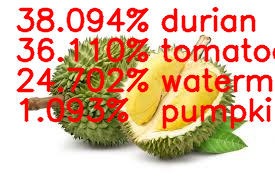

In [87]:
img = cv2.imread("/content/gdrive/MyDrive/Assignment/sample1.jpg")
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
        
img_t = transform(img)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

watermelon 0.9962283372879028
durian 0.0036754438187927008
tomatoes 4.8758447519503534e-05
pumpkin 4.755406916956417e-05


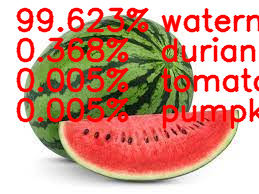

In [88]:
img2 = cv2.imread("/content/gdrive/MyDrive/Assignment/sample2.jpg")
rgb_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
        
img_t = transform(img2)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img2, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img2, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img2)
cv2.waitKey(0)
cv2.destroyAllWindows()

tomatoes 0.7873096466064453
durian 0.18583397567272186
watermelon 0.02684342861175537
pumpkin 1.2945781236339826e-05


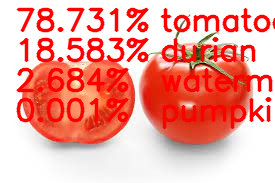

In [90]:
img3 = cv2.imread("/content/gdrive/MyDrive/Assignment/sample3.jpg")
rgb_img = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([transforms.ToPILImage(),         #[1]
transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])
        
img_t = transform(img3)

input_batch = torch.unsqueeze(img_t, 0)
input_batch = input_batch.to(device)
trained_model.eval()

# Carry out inference
out = trained_model(input_batch)

from google.colab.patches import cv2_imshow

classes = ['durian','pumpkin','tomatoes','watermelon']
# Get the softmax probabilities.
probabilities = torch.nn.functional.softmax(out, dim=1)[0]
# Check the 4 categories that are predicted.
top4_prob, top4_catid = torch.topk(probabilities, 4)

for i in range(top4_prob.size(0)):
    cv2.putText(img3, f"{top4_prob[i].item()*100:.3f}%", (15, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(img3, f"{classes[top4_catid[i]]}", (160, (i+1)*30), 
                cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 0, 255), 2, cv2.LINE_AA)
    print(classes[top4_catid[i]], top4_prob[i].item())
    
cv2_imshow(img3)
cv2.waitKey(0)
cv2.destroyAllWindows()